<a href="https://www.kaggle.com/desmondrn/morebikes-all-stations-training-comparison?scriptVersionId=84887780" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
%%capture

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC
from sklearn.linear_model import PoissonRegressor

import joblib

import tensorflow as tf
mae = tf.keras.losses.MeanAbsoluteError()
_ = mae([1], [2]) 

import os

INPUT_DIR = '/kaggle/input/morebikes2021'

FEATURE_SET = 'short_full_temp'            ## Change features here
SHUFFLE_SAMPLES = False                    ## To shuffle the data
TRAIN_SIZE = 0.95                          ## To adjust train size


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

# Objective

This notebook deals with Phase 1 of the Kaggle competition. First, we will build 75 different models for each station (a), then we will build one model for all stations at once (b). After that,  we will compare these two approaches and discus some variables that affect the learning process in both cases. Unless otherwise specified, the models will be trained using the `short_full_temp` feature set, and the training set will contain 95% of the available data. 

# Build all per-station models

We laid out the justification for each envisioned machine learning algorithm in our previous notebook `MoreBikes - Analysis & Per-Station Training`.

In [2]:
def get_peters_features():
    short = ['bikes_3h_ago', 'short_profile_3h_diff_bikes', 'short_profile_bikes']
    short_temp = short + ['temperature.C']
    full = ['bikes_3h_ago', 'full_profile_3h_diff_bikes', 'full_profile_bikes']
    full_temp = full + ['temperature.C']
    short_full = ['bikes_3h_ago', 'short_profile_3h_diff_bikes', 'short_profile_bikes', 'full_profile_3h_diff_bikes', 'full_profile_bikes']
    short_full_temp = short_full + ['temperature.C']
    
    if FEATURE_SET=='short':
        return short
    elif FEATURE_SET=='short_temp':
        return short_temp
    elif FEATURE_SET=='full':
        return full
    elif FEATURE_SET=='full_temp':
        return full_temp
    elif FEATURE_SET=='short_full':
        return short_full
    elif FEATURE_SET=='short_full_temp':
        return short_full_temp
    else:
        return 'all'

def get_train_path(station_id):
    return INPUT_DIR+'/Train/Train/station_'+str(station_id)+'_deploy.csv'

def preprocess(df):
    df = df.drop(['weekday', 'latitude', 'longitude','year', 'month'], axis=1)
#     df = df.drop(['numDocks'], axis=1)
    df = df.drop(['station'], axis=1)
    df['timestamp'] = (df['timestamp'] - 1412114400) / 3600
    return df

def select_peters_features(df):
    features_to_use = get_peters_features()
        
    if features_to_use == 'all':
        return df.dropna()
    else:
#         features_to_use += ['numDocks']         #### Remember to remove this !
        if 'bikes' in list(df.columns):
            features_to_use += ['bikes']
        return df[features_to_use].dropna()
    
def make_learning_data(station_id):
    df = pd.read_csv(get_train_path(station_id))
    
    df = preprocess(df)
#     df = df.sample(frac=1, random_state=12)

    df = select_peters_features(df)

    df_y = df['bikes']
    df_X = df.drop(['bikes'], axis=1)

    return np.array(df_X), np.array(df_y)

# df = make_learning_data(201)
# df

In [3]:
def train_bikes_models(X_train, X_val, y_train, y_val, station_id=0):
    """
    @station_id: id of the station we want to train
    returns the best model for this station
    """

    """ All models that will be trained and their scores """
    potential_models = []

    """### Linear Regression"""
    
#     degrees = [1, 2, 3]
    degrees = [1]
    for i in range(len(degrees)):
        scaled_features = StandardScaler()
        polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
        linear_regression = Ridge()
        pipeline = Pipeline(
            [
                ("scaled_features", scaled_features),
                ("polynomial_features", polynomial_features),
                ("linear_regression", linear_regression),
            ]
        )
        pipeline.fit(X_train, y_train)
        y_pred = np.rint(pipeline.predict(X_val))
        potential_models.append(('linear_reg_'+str(degrees[i]), pipeline, mae(y_val, y_pred).numpy()))

    """### K-Nearest Neighbors"""

#     KNN = KNeighborsClassifier(n_neighbors=2)
#     KNN.fit(X_train, y_train)
#     y_pred = KNN.predict(X_val)
#     potential_models.append(('knn', KNN, mae(y_val, y_pred).numpy()))

    """### Decision Tree"""

#     DcTree = Pipeline([("minmax_scaler", MinMaxScaler()), ("decision_tree", DecisionTreeClassifier(random_state=12))])
#     DcTree.fit(X_train, y_train)
#     y_pred = DcTree.predict(X_val)
#     potential_models.append(('decision_tree', DcTree, mae(y_val, y_pred).numpy()))

    """### Random Forest"""

#     RdFor = Pipeline([("minmax_scaler", MinMaxScaler()), ("random_forest", RandomForestClassifier(n_estimators=1000, max_leaf_nodes=None, n_jobs=-1, random_state=12))])
#     RdFor.fit(X_train, y_train)
#     y_pred = RdFor.predict(X_val)
#     potential_models.append(('random_forest', RdFor, mae(y_val, y_pred).numpy()))

    """### SVM - One vs. Rest"""

#     SVM1 = Pipeline([("minmax_scaler", MinMaxScaler()), ("svm_ovr", OneVsRestClassifier(LinearSVC(random_state=12)))])
#     SVM1.fit(X_train, y_train)
#     y_pred = SVM1.predict(X_val)
#     potential_models.append(('svm_ovr', SVM1, mae(y_val, y_pred).numpy()))

    """### SVM - One vs. One"""

#     SVM2 = Pipeline([("minmax_scaler", MinMaxScaler()), ("svm_ovo", OneVsOneClassifier(SVC(random_state=12)))])
#     SVM2.fit(X_train, y_train)
#     y_pred = SVM2.predict(X_val)
#     potential_models.append(('svm_ovo', SVM2, mae(y_val, y_pred).numpy()))
    
    """### Poisson Regression """

#     Poisreg = Pipeline([("minmax_scaler", MinMaxScaler()), ("pois_reg", PoissonRegressor())])
#     Poisreg.fit(X_train, y_train)
#     y_pred = Poisreg.predict(X_val)
#     potential_models.append(('pois_reg', Poisreg, mae(y_val, y_pred).numpy()))

    """## Sort the models and pick the best"""
    potential_models = sorted(potential_models, key=lambda el:el[2])
   
    return potential_models[0]

In [4]:
## All our models will be stored in this dictionnary
per_station_models = {}

for station_id in range(201, 276):
    X, y = make_learning_data(station_id)
    X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=SHUFFLE_SAMPLES, train_size=TRAIN_SIZE)
    per_station_models[station_id] = train_bikes_models(X_train, X_val, y_train, y_val)[1]
    
per_station_models

{201: Pipeline(steps=[('scaled_features', StandardScaler()),
                 ('polynomial_features',
                  PolynomialFeatures(degree=1, include_bias=False)),
                 ('linear_regression', Ridge())]),
 202: Pipeline(steps=[('scaled_features', StandardScaler()),
                 ('polynomial_features',
                  PolynomialFeatures(degree=1, include_bias=False)),
                 ('linear_regression', Ridge())]),
 203: Pipeline(steps=[('scaled_features', StandardScaler()),
                 ('polynomial_features',
                  PolynomialFeatures(degree=1, include_bias=False)),
                 ('linear_regression', Ridge())]),
 204: Pipeline(steps=[('scaled_features', StandardScaler()),
                 ('polynomial_features',
                  PolynomialFeatures(degree=1, include_bias=False)),
                 ('linear_regression', Ridge())]),
 205: Pipeline(steps=[('scaled_features', StandardScaler()),
                 ('polynomial_features',
          

# Train and predict for all stations together

Now, we will train a single model for all the stations together. The data for this learning task is collected such that 5% of each station's data is left for validation. If the data is not shuffle before splitting, then this 5% corresponds to the last 2 days of the month. We will see below that shuffling the data (or not) has a huge effect on the results.

In [5]:
## Collect learning data (and the stations they comme from)

X, y = make_learning_data(201) 
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=SHUFFLE_SAMPLES, train_size=TRAIN_SIZE)
stations = [201]*len(y_val)
 
for station_id in range(202, 276):
    X_, y_ = make_learning_data(station_id) 
    X_train_, X_val_, y_train_, y_val_ = train_test_split(X_, y_, shuffle=SHUFFLE_SAMPLES, train_size=TRAIN_SIZE)
    
    X_train = np.vstack([X_train, X_train_])
    X_val = np.vstack([X_val, X_val_])    
    y_train = np.concatenate([y_train, y_train_])    
    y_val = np.concatenate([y_val, y_val_])
    
    stations += [station_id]*len(y_val_)

In [6]:
## Save this data for later testing in Phases 2 and 3
np.save('X_val.npy', X_val)
np.save('y_val.npy', y_val)
np.save('stations_val.npy', np.array(stations))

In [7]:
## Shapes
print("Shape of the data for all stations together:")
print(" - train:", X_train.shape, y_train.shape)
print(" - val:  ", X_val.shape, y_val.shape)

print(" - stations for each example:", len(stations))

Shape of the data for all stations together:
 - train: (40725, 6) (40725,)
 - val:   (2175, 6) (2175,)
 - stations for each example: 2175


In [8]:
model_name, all_stations_model = train_bikes_models(X_train, X_val, y_train, y_val)[:2]
all_stations_model

Pipeline(steps=[('scaled_features', StandardScaler()),
                ('polynomial_features',
                 PolynomialFeatures(degree=1, include_bias=False)),
                ('linear_regression', Ridge())])

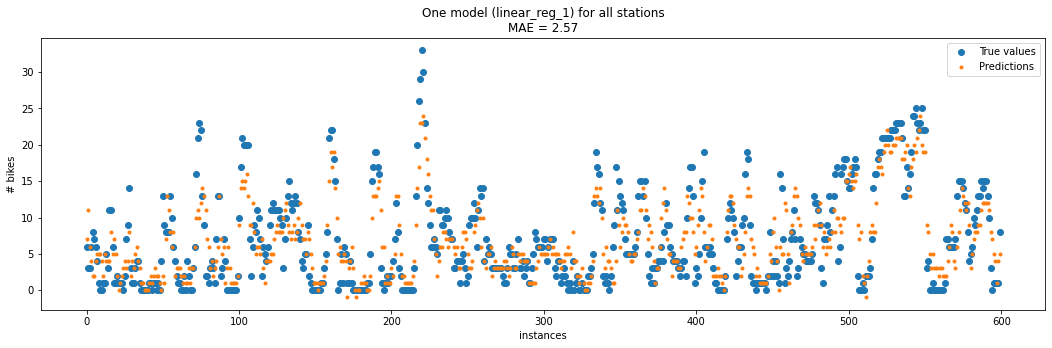

In [9]:
y_pred_all = np.rint(all_stations_model.predict(X_val))

def plot_results(y_pred, title):
    fig, ax = plt.subplots(1, 1, figsize=(18, 5))

    plt.plot(y_val[:600], "o", label="True values")
    ax.plot(y_pred[:600], ".", label="Predictions")
    ax.set_xlabel("instances")
    ax.set_ylabel("# bikes")
    ax.legend(loc="best")
    ax.set_title(
        title+"\nMAE = {:.2f}".format(
            mae(y_val, y_pred).numpy()
        )
    );

plot_results(y_pred_all, title="One model ("+model_name+") for all stations");

In [10]:
## Save the model
joblib.dump(all_stations_model, 'all_stations_model.pkl')

['all_stations_model.pkl']

# Predictions with per-station models

Using the per-station models we've learned so far, let's make predictions (on the same validation set) and compare the results to the only model for all stations above.

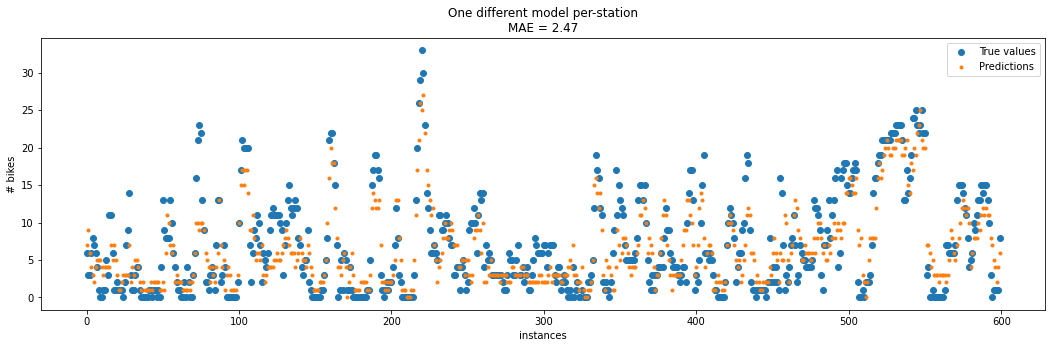

In [11]:
y_pred_per = np.zeros_like(y_val)

for i in range(len(y_val)):
    station_id = stations[i]
    y_pred_per[i] = np.rint(per_station_models[station_id].predict([X_val[i]]))
    
plot_results(y_pred_per, title="One different model per-station");

In [12]:
## Save the models
joblib.dump(per_station_models, 'per_station_models.pkl')

['per_station_models.pkl']

# Comparing the two approaches

## Should we shuffle the data ?
For this first comparison, we will restrict the models to a single category, and for each category (or learning algorithm), we will study the effect of shuffling the data. To better illustrate the rift between these two strategies, we used 80% of the available data for training, and the remaining 20% for validating: 

- **Without shuffling the data**: models are trained on the 25 first days of the month, and validated on the remaining 6 days:

| Algorithm      | All-stations | Per-station |
| :---        |    :----:   |          :---: |
| Linear Regression - 1      | 2.66       |2.63|
| Linear Regression - 2   |    2.61     |2.54|
| Linear Regression - 3   |    2.54     |2.70|
| K-Nearest Neighbors   |    3.21     |3.20|
| Decision Tree   |    3.38     |3.40|
| Random Forest   |    3.05    |3.17|
| SVM - One vs. Rest   |   4.05      |3.48|
| SVM - One vs. One   |    2.90     |3.12|
| Poisson Regression   |    4.40     |3.56|

- **When shuffling the data**: the training data contains some hours of every day of the month, and the same goes for the validation data:

| Algorithm      | All-stations | Per-station |
| :---        |    :----:   |          :---: |
| Linear Regression - 1      | 2.70       |2.53|
| Linear Regression - 2   |    2.61     |2.36|
| Linear Regression - 3   |    2.60     |2.25|
| K-Nearest Neighbors   |    3.26     |1.58|
| Decision Tree   |    3.35     |0.57|
| Random Forest   |    3.12    |0.50|
| SVM - One vs. Rest   |   3.91      |3.02|
| SVM - One vs. One   |    2.86     |2.43|
| Poisson Regression   |    4.44     |3.31|

The conclusion we draw after these comparisons is that training multiple models (one for each station) is almost always better than training a single model for all stations. This is especially true when the training data is representative of the whole dataset (with shuffling). When this is not the case (without shuffling), we observe exceptions with some models (Decision Trees, Random Forest, etc.) that perform better when trained on all stations together. Considering that those are also the most computationally costly models, we opted in the next Phases to use the per-stations models trained on unshuffled data. 

## Linear Regression models with Peter's Features
One of the best algorithms for this task is clearly the classic version of linear regression (`Linear Regression - 1` where the features are *not* raised to a power before fitting the algorithm). We've only used the `short_full_temp` feature set so far, and the table below shows that the choice of feature set hardly changes the results.

| Features      | All-stations | Per-station |
| :---        |    :----:   |          :---: |
| short      |   2.57     |2.46|
| short_temp   |    2.57     |2.47|
| full   |    2.57     |2.46|
| full_temp   |   2.57      |2.47|
| short_full   |   2.57      |2.45|
| short_full_temp   |   2.57     | 2.47 |

## With a wide range of different models

Each station is now trained on all 9 possible learning algorithms, and only the best model is kept for that station. The same goes for the model for all stations together. As we see in the table below, shuffling produces better results. However, as we have discussed in the previous notebook, not shuffling the data prepares our models for the competition by taking **data drifting** into account. This is why we did not shuffle the data for our submissions for the competition.

|       | **All-stations** | **Per-station**  |
| :---        |    :----:   |          :---: |
|    Without shuffling   |   2.54     |2.45|
|   When shuffling |    2.53    |1.55|

# Predictions for the competition

Now, we will generate and save predictions for the Kaggle competition. As we have stated over the course of this notebook, other quantities have been saved and will be needed to run the final phases of the competition in the next notebook.

In [13]:
def make_test_data():
    df = pd.read_csv(INPUT_DIR+'/test.csv')
    
    station_ids = df['station']
    
    df = preprocess(df)
    
    ids = df['Id']
    df = df.drop(['Id'], axis=1)
    
    df = select_peters_features(df)
    
    return np.array(df), np.array(ids), np.array(station_ids)
    
X_test, ids, station_ids = make_test_data()
X_test.shape

(2250, 6)

In [14]:
## Save this data for later testing in Phases 2 and 3
np.save('X_test.npy', X_test)
np.save('ids_test.npy', ids)
np.save('stations_test.npy', station_ids)

In [15]:
""" If we chose to all stations at once """
# y_pred = all_stations_model.predict(X_test)

""" If we chose one model per-station """
y_pred = np.zeros((len(X_test)))
for i in range(len(X_test)):
    station_id = station_ids[i]
    y_pred[i] = per_station_models[station_id].predict([X_test[i]])

# np.unique(y_pred)
results = pd.DataFrame({'Id':ids, 'bikes':np.rint(y_pred)})
results

,Id,bikes
0,1,3.0
1,2,3.0
2,3,9.0
3,4,4.0
4,5,3.0
...,...,...
2245,2246,11.0
2246,2247,12.0
2247,2248,7.0
2248,2249,13.0


In [16]:
results.to_csv('/kaggle/working/roussel_subin_submission.csv', index=False)

## View all assets that will be needed for phases 2 and 3
os.listdir('/kaggle/working/')

['X_val.npy',
 'all_stations_model.pkl',
 'stations_val.npy',
 '__notebook__.ipynb',
 'per_station_models.pkl',
 'roussel_subin_submission.csv',
 'ids_test.npy',
 'X_test.npy',
 'stations_test.npy',
 'y_val.npy']